In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import random
import os
import cv2
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from PIL import Image
from PIL import ImageFilter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/Colab\ Datasets/DL\ Final/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [4]:
!ls 

drive  labels.csv  sample_data	sample_submission.csv  test  train


In [5]:
label_data = pd.read_csv("./labels.csv")

In [6]:
label_data.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [7]:
len(label_data["breed"].unique())

120

#### Visualization

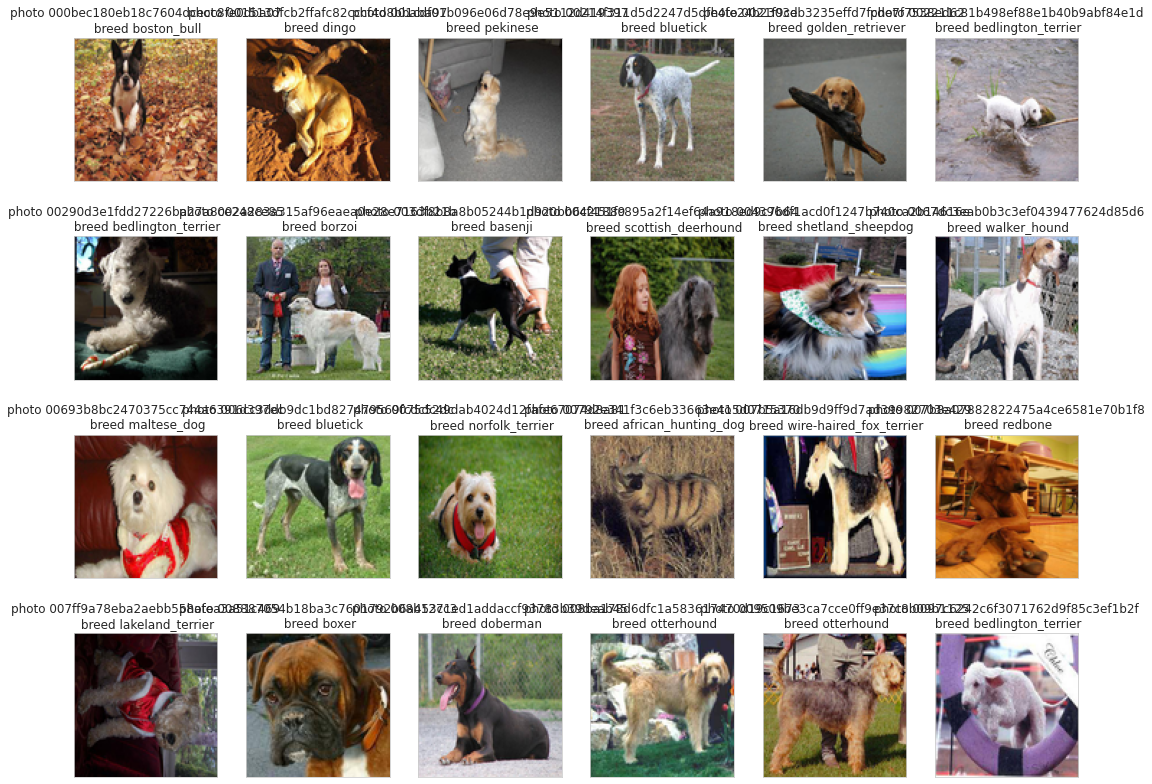

In [ ]:
# Display the first 24 images in the training dataset
fig = plt.figure(figsize = (18,14))
for i in range(24):
    img = Image.open('./train/' + str(label_data.loc[i][0]) + '.jpg')
    img = img.resize((100, 100), Image.ANTIALIAS)
    ax = fig.add_subplot(4, 6, i+1, xticks = [], yticks = [])
    ax.set_title('photo ' + str(label_data.loc[i][0]) + '\n breed ' + str(label_data.loc[i][1]))
    ax.imshow(img)

Average Images per breed:85
Total no of breeds:120


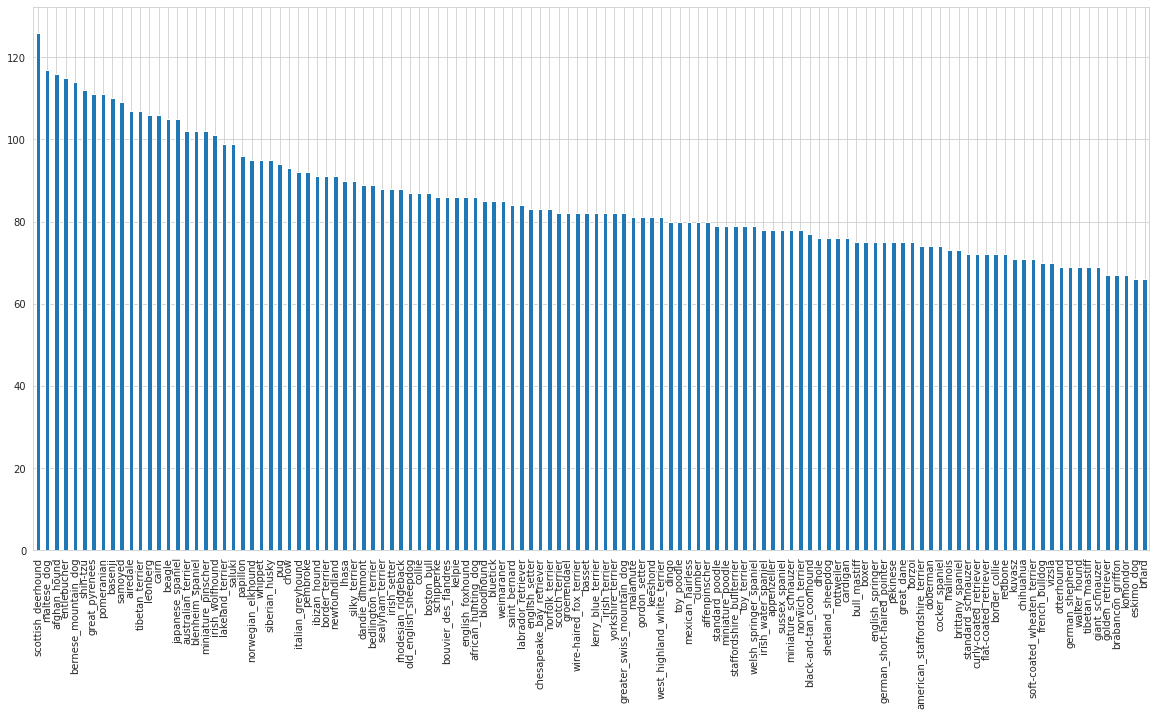

In [ ]:
#Check how many images per breed of dog. 

label_data['breed'].value_counts().plot.bar(figsize=(20,10))
print(f"Average Images per breed:{int(label_data['breed'].value_counts().sum()/len(label_data['breed'].unique()))}")
print(f"Total no of breeds:{len(label_data['breed'].unique())}")

#### Preprocess

In [8]:
#Create an array of train images 
filenames = ["./train/" + fname + '.jpg' for fname in label_data['id']]
filenames[:10]

['./train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './train/001cdf01b096e06d78e9e5112d419397.jpg',
 './train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './train/002a283a315af96eaea0e28e7163b21b.jpg',
 './train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Create class names array 
class_names = label_data['breed'].unique()
class_names[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog'], dtype=object)

In [10]:
target_labels = [breed for breed in label_data['breed']]
target_labels[:10]

['boston_bull',
 'dingo',
 'pekinese',
 'bluetick',
 'golden_retriever',
 'bedlington_terrier',
 'bedlington_terrier',
 'borzoi',
 'basenji',
 'scottish_deerhound']

In [11]:
#one-hot encoding

target_labels_encoded = [label == np.array(class_names) for label in target_labels]
target_labels_encoded[:2]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False,  True, False, False, False, Fal

In [12]:
print(target_labels[0]) # original label
print(np.where(class_names == target_labels[0])[0][0]) # index where label occurs
print(target_labels_encoded[0].argmax()) # index where label occurs in boolean array
print(target_labels_encoded[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
0
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Split data

In [13]:
#Import train test split from sklearn 

from sklearn.model_selection import train_test_split 

#Experiement with small data 1000 images 
NUM_IMAGES = 2000

#Split data into training & validation 
X_train, X_val, Y_train, Y_val = train_test_split(filenames[:NUM_IMAGES], target_labels_encoded[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(Y_train), len(Y_val)

(1600, 400, 1600, 400)

In [14]:
X_train[0], Y_train[0]

('./train/17c5e8815cf0d086090a07b003b9b036.jpg',
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]

### Image Resize

In [15]:
IMAGE_SIZE = 224

# Lets write our preprocessing function
def process_image(image_path): 
    """
    This function will read image, resize the image and return into TF format. 
    Arguments: 
        image_path(str): Path of image
    Returns: 
        img: Tensor image
    """
    img = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    img = tf.io.decode_image(img, channels =3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to our desired size (224, 244)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    return img

In [16]:
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

get_image_label(X_train[10], Y_train[10])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.37254903, 0.5764706 , 0.19215688],
         [0.36862746, 0.56078434, 0.20392159],
         [0.3372549 , 0.50980395, 0.20000002],
         ...,
         [1.        , 0.92549026, 0.3647059 ],
         [0.9843138 , 0.909804  , 0.36862746],
         [1.        , 0.9450981 , 0.43921572]],
 
        [[0.34901962, 0.52156866, 0.14117648],
         [0.3254902 , 0.49411768, 0.13333334],
         [0.37647063, 0.5411765 , 0.21176472],
         ...,
         [0.69411767, 0.6745098 , 0.18039216],
         [0.7803922 , 0.7568628 , 0.28627452],
         [0.7411765 , 0.7254902 , 0.29411766]],
 
        [[0.30980393, 0.4666667 , 0.09019608],
         [0.34509805, 0.5058824 , 0.13725491],
         [0.4156863 , 0.5803922 , 0.24313727],
         ...,
         [0.40784317, 0.43137258, 0.01568628],
         [0.5372549 , 0.5568628 , 0.16470589],
         [0.38431376, 0.41176474, 0.04705883]],
 
        ...,
 
        [[0.56078434, 0.7607844 

In [17]:
BATCH_SIZE = 32 

#Create function to create dataset batches 
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data=False): 
    """
    This function will help to accept Train Images (X) and labels (y). 
    Also Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    if test_data: 
        print("Creating Test data")
        test_data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        test_data = test_data.map(process_image).batch(BATCH_SIZE) 
        return test_data 

    #Create validation data
    if valid_data: 
        print("Creating Validation data")
        valid_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        valid_data = valid_data.map(get_image_label).batch(BATCH_SIZE)
        return valid_data
    
    #Shuffle and create training data
    else: 
        print("Creating Training Data") 
        train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))).shuffle(buffer_size = len(X))
        train_data = train_data.map(get_image_label).batch(BATCH_SIZE) 
        return train_data 

In [18]:
train_data = create_data_batches(X_train, Y_train)
valid_data = create_data_batches(X_val, Y_val, valid_data= True)

Creating Training Data
Creating Validation data


### Train data visualization

In [ ]:
import matplotlib.pyplot as plt 

def show_images(images, label): 
    """
    Display 25 Images with labels. 
    """
    #Setup the figure 
    plt.figure(figsize = (12,12)) 
    for i in range(0,25): 
        ax = plt.subplot(5, 5, i+1)
        
        plt.imshow(images[i])
        
        plt.title(class_names[tf.argmax(label[i])])
        
        plt.axis("off")

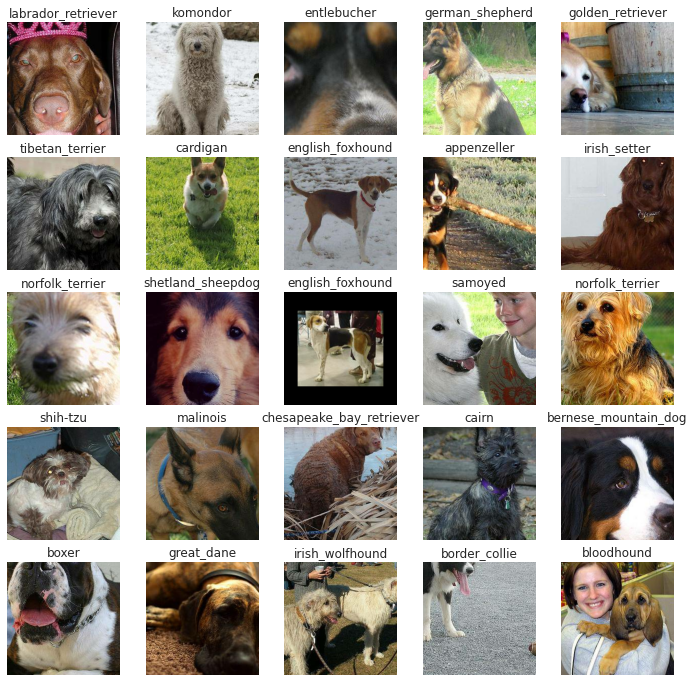

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

### Validation data visualization

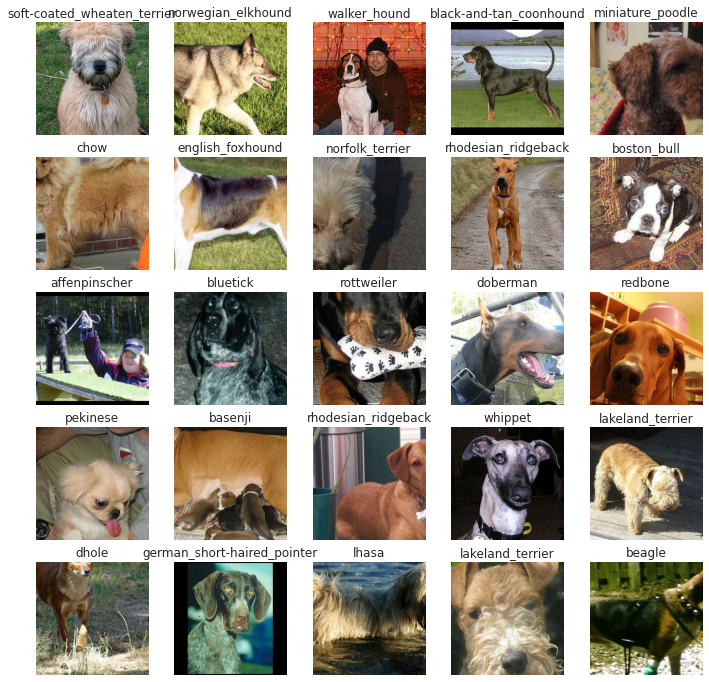

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_images(val_images, val_labels)

### Create Model - EffcientNetB0

In [19]:
import tensorflow as tf 
from tensorflow.keras import layers 

def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, 
                                                     classes = len(class_names)) 
    base_model.trainable = False 

    inputs = layers.Input(shape = (224,224,3))
    x = base_model(inputs, training = False) 
    x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling")(x)
    x = layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)


    ModelDogBreed = tf.keras.Model(inputs, outputs) 

    ModelDogBreed.compile(loss = "categorical_crossentropy", 
                         optimizer = tf.keras.optimizers.Adam(), 
                         metrics=["accuracy"]) 

    return ModelDogBreed

In [20]:
model = create_model()

# Callbacks 

EarlyStoppingCallbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, baseline=None, restore_best_weights=True
)

9420800/9406464 [==============================] - 0s 0us/step


In [21]:
ModelDogBreed_History = model.fit(train_data, 
                                         steps_per_epoch = len(train_data),
                                         epochs = 1000, 
                                         validation_data= valid_data, 
                                         validation_steps = len(valid_data),
                                         callbacks = [EarlyStoppingCallbacks])

Epoch 1/1000
50/50 [==============================] - 78s 1s/step - loss: 4.0899 - accuracy: 0.1306 - val_loss: 2.7066 - val_accuracy: 0.4275
Epoch 2/1000
50/50 [==============================] - 63s 1s/step - loss: 1.7055 - accuracy: 0.6244 - val_loss: 1.9619 - val_accuracy: 0.5300
Epoch 3/1000
50/50 [==============================] - 60s 1s/step - loss: 0.9392 - accuracy: 0.8363 - val_loss: 1.7164 - val_accuracy: 0.5600
Epoch 4/1000
50/50 [==============================] - 72s 1s/step - loss: 0.5962 - accuracy: 0.9112 - val_loss: 1.5982 - val_accuracy: 0.5850
Epoch 5/1000
50/50 [==============================] - 60s 1s/step - loss: 0.4245 - accuracy: 0.9500 - val_loss: 1.5331 - val_accuracy: 0.6025
Epoch 6/1000
50/50 [==============================] - 60s 1s/step - loss: 0.3047 - accuracy: 0.9719 - val_loss: 1.5184 - val_accuracy: 0.5825
Epoch 7/1000
50/50 [==============================] - 60s 1s/step - loss: 0.2239 - accuracy: 0.9887 - val_loss: 1.4950 - val_accuracy: 0.5900
Epoch 

In [22]:
model.evaluate(valid_data)

13/13 [==============================] - 18s 1s/step - loss: 1.4379 - accuracy: 0.6125


[1.4379230737686157, 0.612500011920929]

### Loss Curve

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

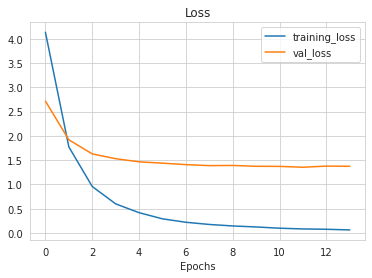

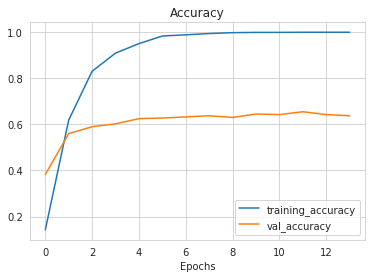

In [ ]:
plot_loss_curves(ModelDogBreed_History)

### Prediction on validation data

In [24]:
predictions = model.predict(valid_data)
predictions

array([[1.10757508e-04, 3.69601185e-05, 8.77525308e-05, ...,
        1.50218045e-06, 3.37875717e-05, 4.71491876e-06],
       [7.26945436e-05, 1.56076683e-03, 3.08345875e-06, ...,
        3.05485651e-06, 2.90892990e-06, 1.58914016e-04],
       [7.50849908e-03, 2.20051402e-06, 6.56209181e-07, ...,
        1.52404525e-03, 1.08454915e-05, 1.08995599e-04],
       ...,
       [1.20844297e-05, 2.64051341e-04, 1.33020853e-06, ...,
        1.53316414e-05, 1.13982917e-03, 3.03293520e-04],
       [7.38601784e-06, 7.02520338e-05, 9.31709019e-06, ...,
        8.69465069e-08, 1.41374164e-06, 7.21449487e-06],
       [7.39643065e-06, 1.88845632e-07, 8.62196941e-07, ...,
        2.50704574e-07, 1.15034993e-06, 1.64006167e-06]], dtype=float32)

In [25]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'soft-coated_wheaten_terrier'

In [26]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.48235297, 0.56078434, 0.3137255 ],
         [0.3803922 , 0.4666667 , 0.21568629],
         [0.33333334, 0.43137258, 0.1764706 ],
         ...,
         [0.32941177, 0.48627454, 0.2784314 ],
         [0.30588236, 0.454902  , 0.25490198],
         [0.32156864, 0.44705886, 0.2627451 ]],
 
        [[0.43529415, 0.5176471 , 0.25490198],
         [0.47450984, 0.56078434, 0.30588236],
         [0.2901961 , 0.3921569 , 0.13725491],
         ...,
         [0.3529412 , 0.48627454, 0.28627452],
         [0.31764707, 0.4431373 , 0.2509804 ],
         [0.30588236, 0.41176474, 0.23529413]],
 
        [[0.2509804 , 0.33333334, 0.0627451 ],
         [0.5254902 , 0.6156863 , 0.34901962],
         [0.38823533, 0.48627454, 0.227451  ],
         ...,
         [0.29803923, 0.40784317, 0.21568629],
         [0.27450982, 0.37647063, 0.19215688],
         [0.2784314 , 0.3803922 , 0.20392159]],
 
        ...,
 
        [[0.21176472, 0.33333334, 0.20784315],
         [0.24705884, 0.36862746, 0.24705

In [27]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

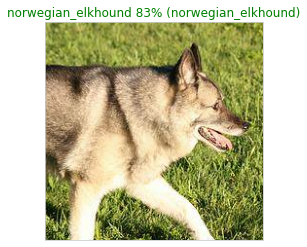

In [28]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [29]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = class_names[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

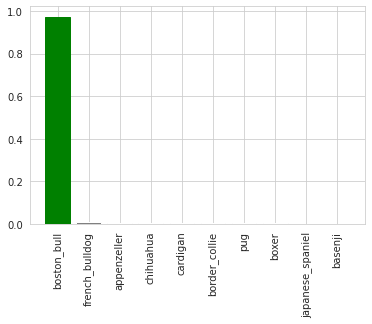

In [30]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

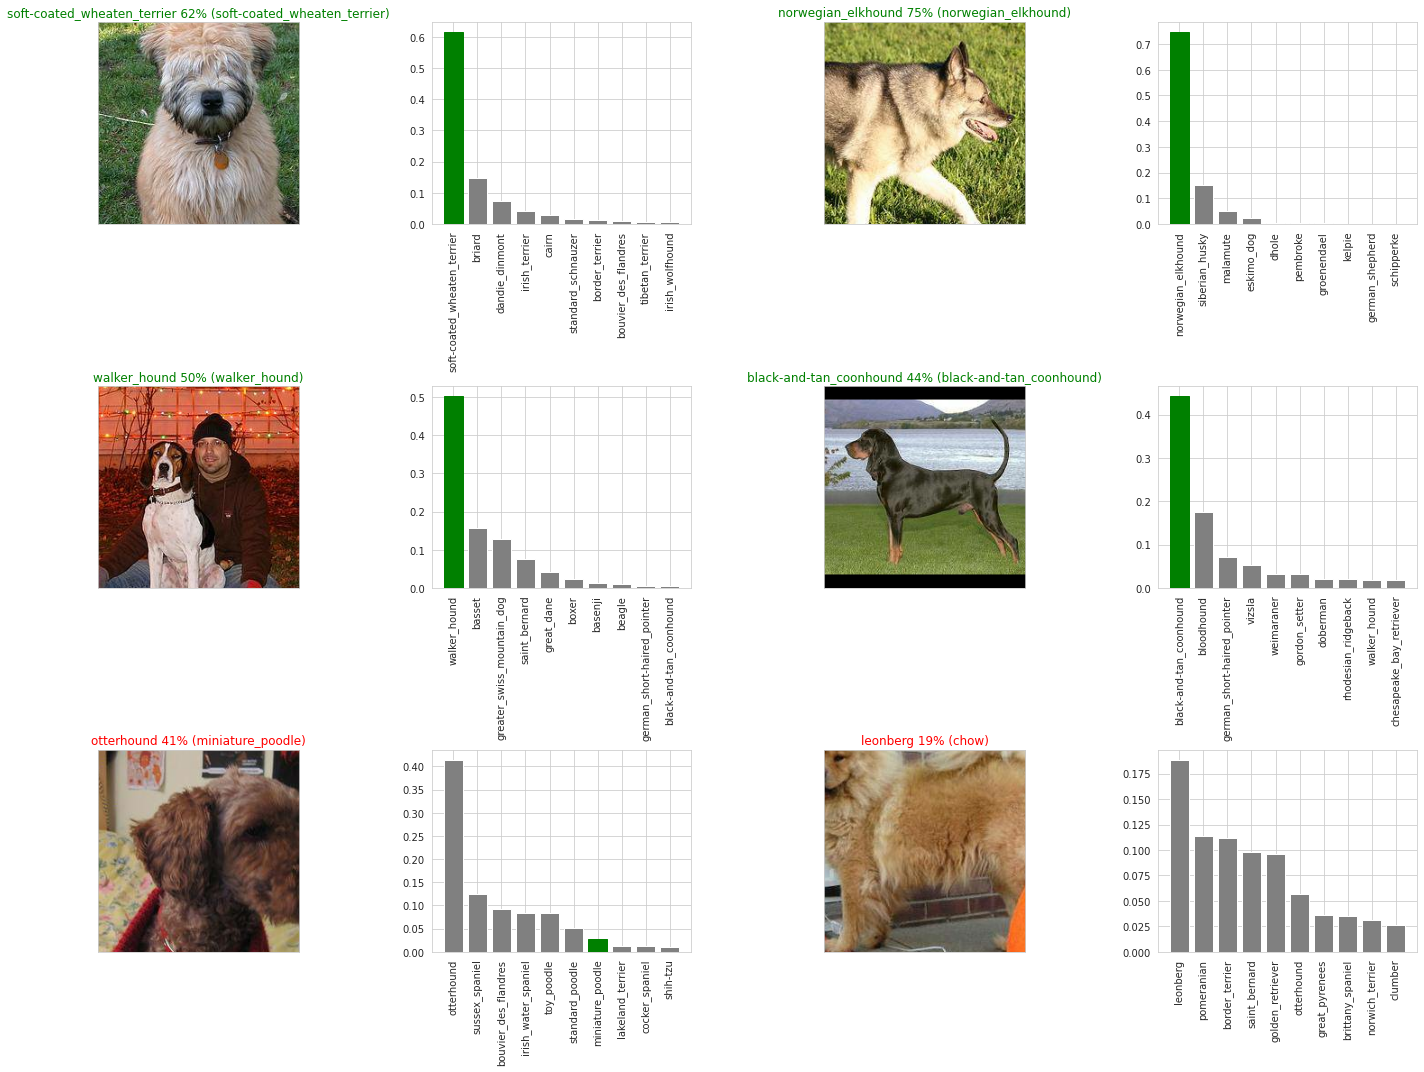

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Test on our dogs

In [64]:
class_names

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [164]:
X_val = ['drive/MyDrive/Colab Datasets/DL Final/a.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/b.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/c.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/d.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/e.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/f.jpg',
         'drive/MyDrive/Colab Datasets/DL Final/g.jpg']
X_val

['drive/MyDrive/Colab Datasets/DL Final/a.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/b.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/c.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/d.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/e.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/f.jpg',
 'drive/MyDrive/Colab Datasets/DL Final/g.jpg']

In [165]:
Y_val = [np.array([i == "maltese_dog" for i in class_names]),
         np.array([i == "pomeranian" for i in class_names]),
         np.array([i == "pomeranian" for i in class_names]),
         np.array([i == "german_shepherd" for i in class_names]),
         np.array([i == "pomeranian" for i in class_names]),
         np.array([i == "maltese_dog" for i in class_names]),
         np.array([i == "german_shepherd" for i in class_names])]
#Y_val

In [166]:
valid_data = create_data_batches(X_val, Y_val, valid_data= True)

Creating Validation data


In [167]:
predictions = model.predict(valid_data)
#predictions

In [168]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
#pred_label = get_pred_label(predictions[0])
#pred_label

In [169]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
#val_images[0], val_labels[0]

In [170]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [171]:
# View an example prediction, original image and truth label
#plot_pred(prediction_probabilities=predictions,
#          labels=val_labels,
#          images=val_images, n=0)

In [172]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = class_names[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [173]:
#plot_pred_conf(prediction_probabilities=predictions,
#               labels=val_labels, n=0)

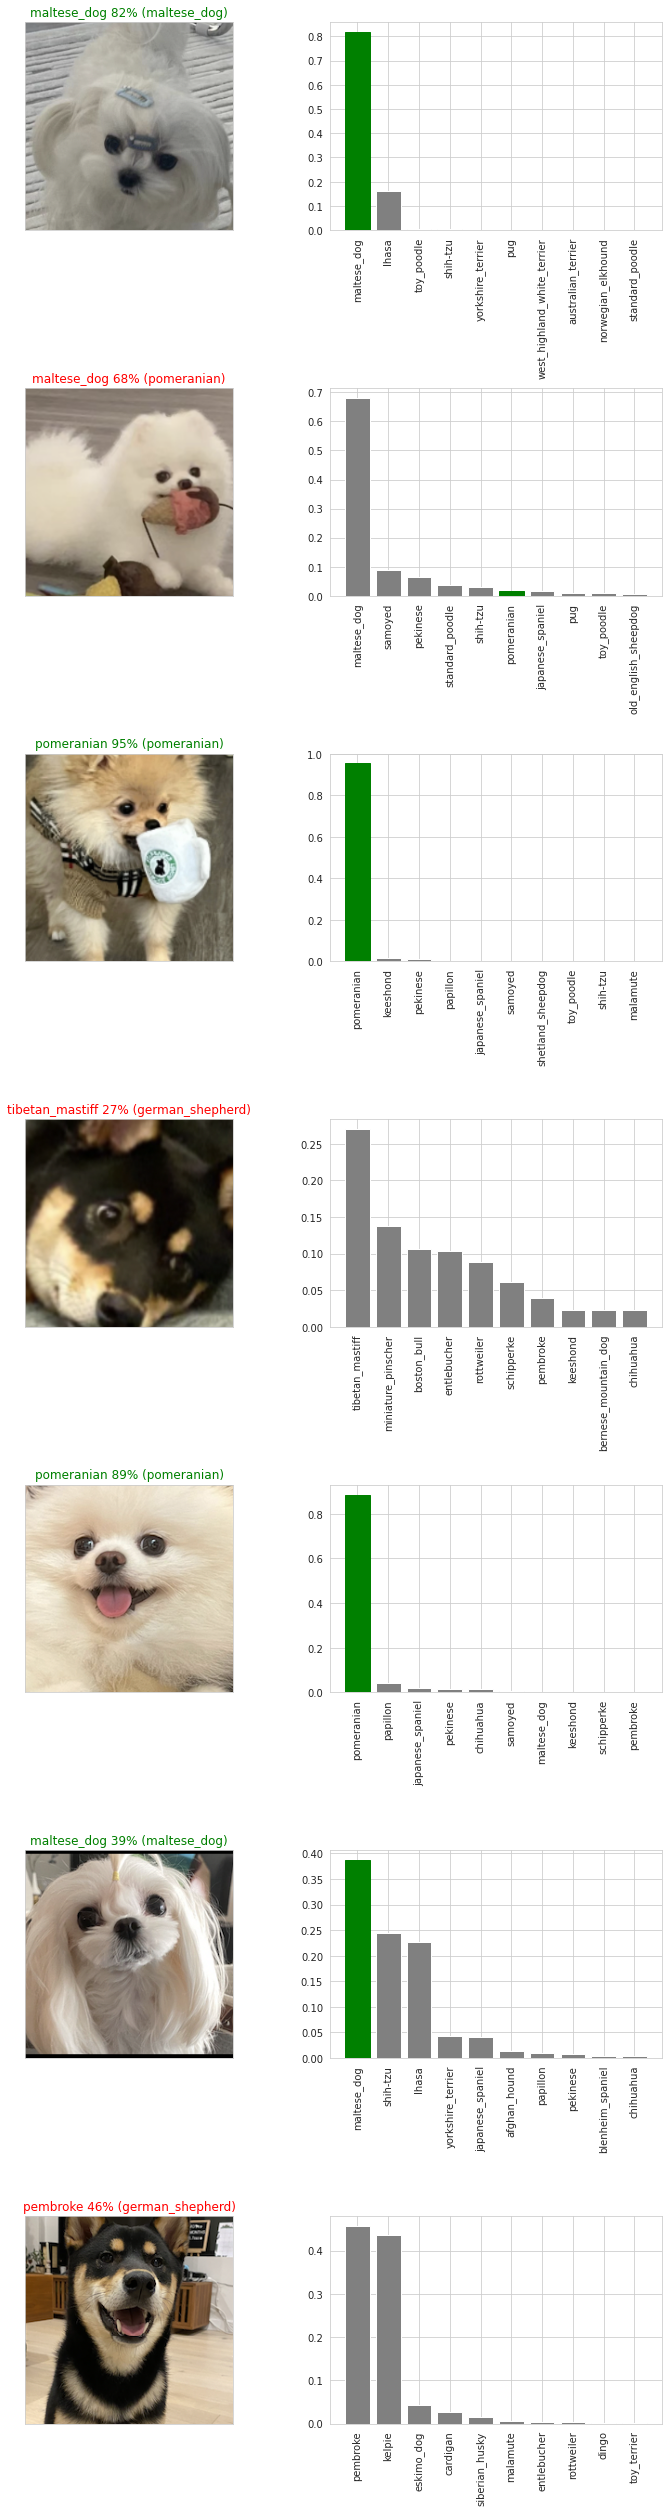

In [174]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 7
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()